# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable, select_first_encounter, reduce_dimension_ndc, patient_dataset_splitter_tf, create_tf_categorical_feature_cols, get_mean_std_from_preds, get_binary_prediction
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response:It's at the line level. 

In [4]:
df.shape, df.encounter_id.nunique(), df.patient_nbr.nunique()

((143424, 26), 101766, 71518)

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions: 

    - a. Field(s) with high amount of missing/zero values
     
         'weight', 'payer_code', 'medical_specialty'
    
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    
         'num_medications' and 'num_lab_procecures' follows normal distribution
   
    - c. Which field(s) have high cardinality and why 
    
          High cardinality columns include 'other_diagnosis_codes', 'primary_diagnosis_code', 'ndc_code' due to the nature of codes. 
         
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
          
          Age peaks in the 70-80 group and follows normal distribution. There are more women than men. 
 

In [5]:
df = df.replace('?', np.nan).replace('None', np.nan)

In [6]:
# weight, 'max_glu_serum', 'A1Cresult', medical_specialty, payer_code, and ndc_code have a high percentage of null values
df.isnull().mean().sort_values(ascending=False)

weight                      0.970005
max_glu_serum               0.951089
A1Cresult                   0.820295
medical_specialty           0.484319
payer_code                  0.377831
ndc_code                    0.163585
race                        0.023071
primary_diagnosis_code      0.000230
patient_nbr                 0.000000
gender                      0.000000
age                         0.000000
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
readmitted                  0.000000
change                      0.000000
other_diagnosis_codes       0.000000
number_outpatient           0.000000
number_inpatient            0.000000
number_emergency            0.000000
num_lab_procedures          0.000000
number_diagnoses            0.000000
num_medications             0.000000
num_procedures              0.000000
encounter_id                0.000000
dtype: float64

In [7]:
# remove columns with high null percentage
df = df.drop(columns = ['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      140115 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   admission_type_id         143424 non-null  int64 
 6   discharge_disposition_id  143424 non-null  int64 
 7   admission_source_id       143424 non-null  int64 
 8   time_in_hospital          143424 non-null  int64 
 9   primary_diagnosis_code    143391 non-null  object
 10  other_diagnosis_codes     143424 non-null  object
 11  number_outpatient         143424 non-null  int64 
 12  number_inpatient          143424 non-null  int64 
 13  number_emergency          143424 non-null  int64 
 14  num_

In [9]:
# identify categorical columns
cat_col = list(df.select_dtypes(['object']).columns)
cat_col.extend(['admission_type_id','discharge_disposition_id', 'admission_source_id'])
for col in cat_col:
    df[col] = df[col].astype(str)

In [10]:
# high cardinality columns include 'other_diagnosis_codes', 'primary_diagnosis_code', 'ndc_code'
cat_df = df[cat_col]
cardinality_df = pd.DataFrame({'columns': cat_df.columns, 'cardinality': cat_df.nunique() } )
cardinality_df.sort_values('cardinality', ascending=False)

,columns,cardinality
other_diagnosis_codes,other_diagnosis_codes,19374
primary_diagnosis_code,primary_diagnosis_code,717
ndc_code,ndc_code,252
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
age,age,10
admission_type_id,admission_type_id,8
race,race,6
gender,gender,3
readmitted,readmitted,3


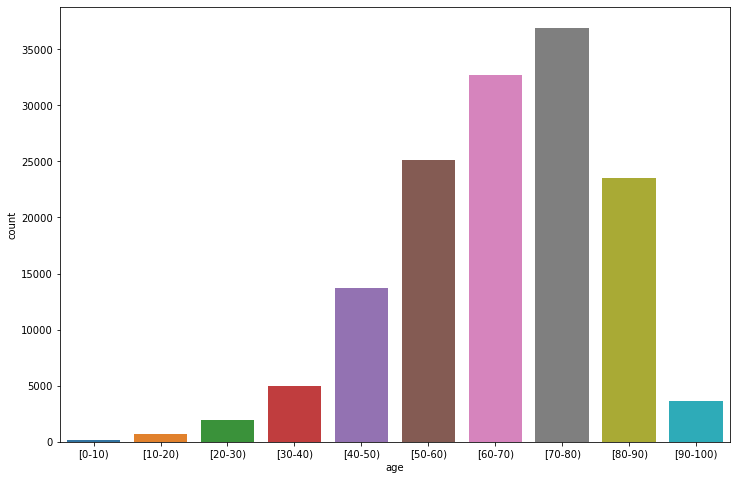

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(x='age', data=df); 

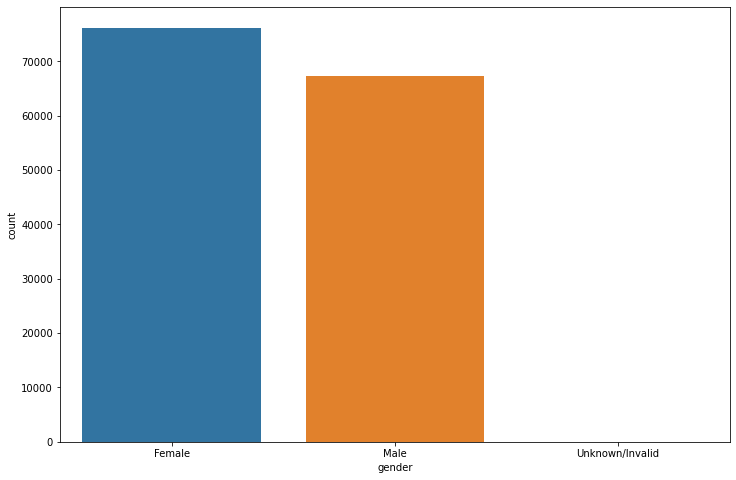

In [12]:
plt.figure(figsize=(12, 8))
sns.countplot(x='gender', data=df); 

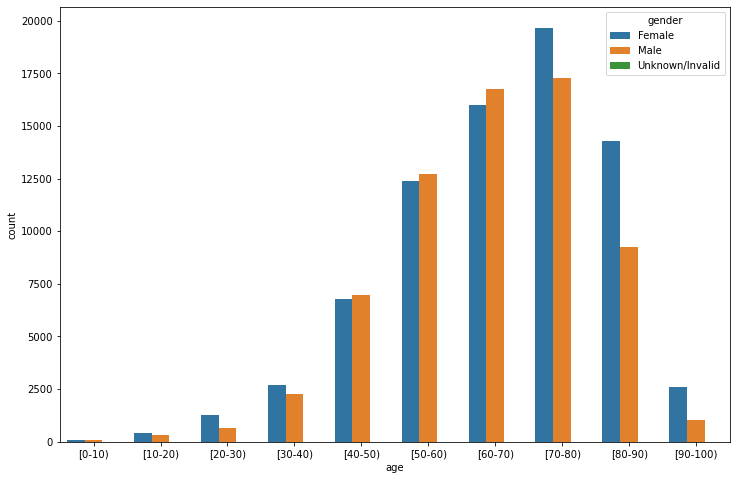

In [13]:
# distribution of age and gender
plt.figure(figsize=(12, 8))
sns.countplot(x="age", hue="gender", data=df); 

In [14]:
df.select_dtypes(['int64']).columns

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures'],
      dtype='object')

In [15]:
num_col = ['time_in_hospital', 'number_outpatient','number_inpatient', 'number_emergency', 'num_lab_procedures','number_diagnoses', 'num_medications', 'num_procedures']
df[num_col].describe()

,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


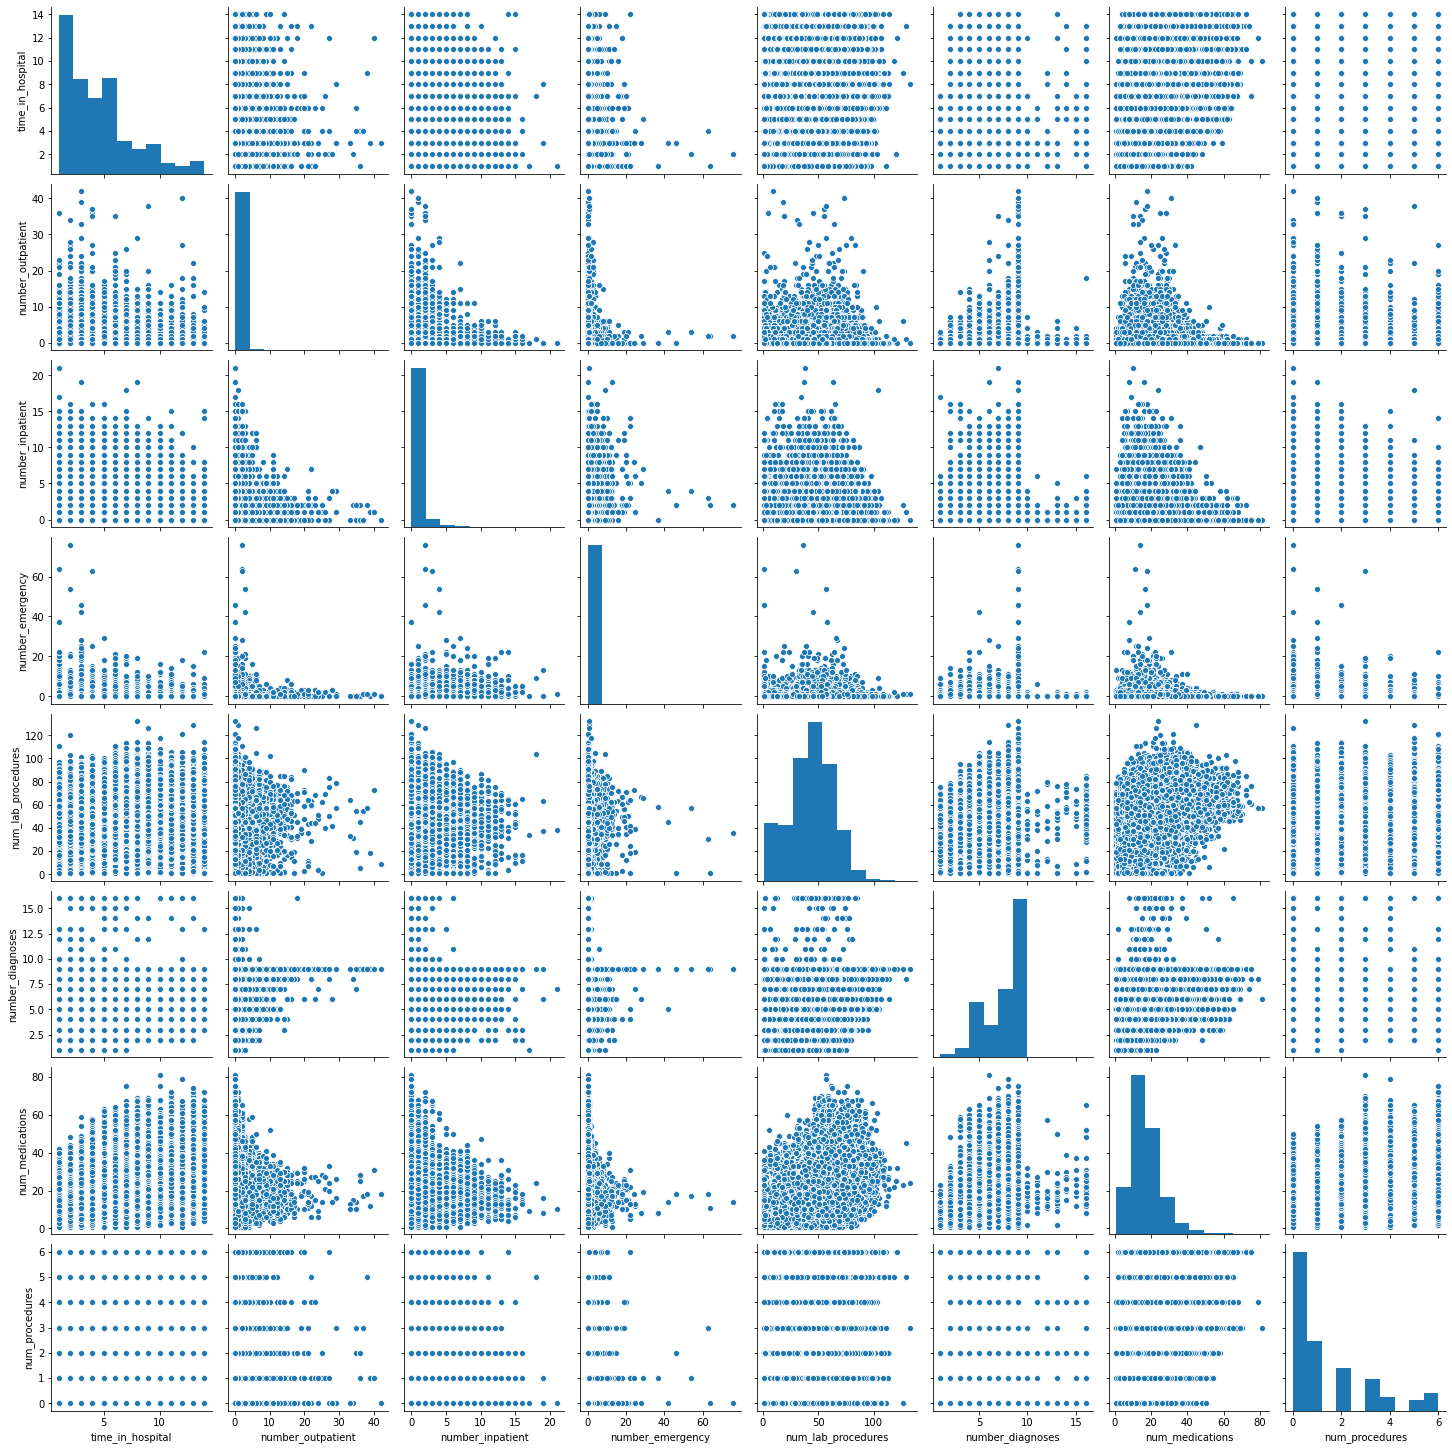

In [16]:
# num_medications and num_lab_procecures follows normal distribution
sns.pairplot(df[num_col]);

In [17]:
######NOTE: The visualization will only display in Chrome browser. ########
# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [18]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [19]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,276,250.01|255,0,0,0,59,9,18,0,Ch,>30,Human Insulin
1,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,8,250.43|403,0,0,0,44,7,16,1,Ch,NO,Human Insulin
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,Ch,NO,Human Insulin
3,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,434,198|486,0,0,0,33,8,18,3,Ch,NO,Human Insulin
4,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,250.7,403|996,0,0,0,47,9,17,2,No,>30,Human Insulin


In [20]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [21]:
# aggregate lines into encounter
non_grouped_field_list = ['generic_drug_name']
grouped_field_list = ['encounter_id', 'patient_nbr']
encounter_df = reduce_dim_df.groupby(grouped_field_list)[non_grouped_field_list] \
                            .agg(lambda x: '|'.join([y for y in x if y is not np.nan ])) \
                            .reset_index()
encounter_df.head()

,encounter_id,patient_nbr,generic_drug_name
0,12522,48330783,Glipizide|Human Insulin
1,15738,63555939,Human Insulin|Rosiglitazone Maleate
2,16680,42519267,Human Insulin|Glipizide
3,28236,89869032,Human Insulin
4,35754,82637451,Human Insulin


In [22]:
# add the rest of the columns
col = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'primary_diagnosis_code', 'other_diagnosis_codes',
       'number_outpatient', 'number_inpatient', 'number_emergency',
       'num_lab_procedures', 'number_diagnoses', 'num_medications',
       'num_procedures', 'change', 'readmitted']

encounter_df = pd.merge(reduce_dim_df[col], encounter_df, on=['encounter_id', 'patient_nbr'], how='left')
encounter_df.drop_duplicates(subset=col, inplace=True)
encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,276,250.01|255,0,0,0,59,9,18,0,Ch,>30,Human Insulin
1,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,8,250.43|403,0,0,0,44,7,16,1,Ch,NO,Human Insulin
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,Ch,NO,Human Insulin|Glipizide
3,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,434,198|486,0,0,0,33,8,18,3,Ch,NO,Human Insulin|Rosiglitazone Maleate
4,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,250.7,403|996,0,0,0,47,9,17,2,No,>30,Human Insulin


In [23]:
first_encounter_df = select_first_encounter(encounter_df)

In [24]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [25]:
# normalize num_col
num_col.remove('time_in_hospital')
agg_drug_df = first_encounter_df.copy()
scaler = StandardScaler()
normalized_num_col = ['normalized_' + col for col in num_col]
scaled_data = pd.DataFrame(scaler.fit_transform(agg_drug_df[num_col]), columns=normalized_num_col)
agg_drug_df = pd.concat([agg_drug_df, scaled_data], axis=1)

In [26]:
ndc_col_list = sorted(reduce_dim_df.generic_drug_name.unique())
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide And Metformin Hcl',
 'Glyburide',
 'Glyburide And Metformin Hydrochloride',
 'Human Insulin',
 'Metformin Hcl',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole And Metformin Hydrochloride',
 'Pioglitazone',
 'Pioglitazone And Glimepiride',
 'Pioglitazone Hydrochloride And Glimepiride',
 'Repaglinide',
 'Rosiglitazone Maleate',
 'Tolazamide',
 'Tolbutamide']

In [27]:
# one hot code 'generic_drug_name'
for col in ndc_col_list:
    agg_drug_df[col]  = agg_drug_df['generic_drug_name'].apply(lambda x: 1 if col in x else 0)

In [28]:
other_dx_code = []
for x in agg_drug_df.other_diagnosis_codes.unique():
    other_dx_code.extend(x.split('|'))
other_dx_code = set(other_dx_code)
pri_dx_code = set(agg_drug_df.primary_diagnosis_code.unique())
dx_code = list(other_dx_code.union(pri_dx_code))
dx_code = sorted(set([x.split('.')[0] for x in dx_code if (x !='?') & (type(x) == type('12'))]))

In [29]:
# one hot code 'dx_code'
agg_drug_df['dx_code'] = agg_drug_df.other_diagnosis_codes + '|' + agg_drug_df.primary_diagnosis_code
agg_drug_df['dx_code'] = agg_drug_df['dx_code'].astype(str)
for col in dx_code:
    agg_drug_df[col]  = agg_drug_df['dx_code'].apply(lambda x: 1 if col in x else 0)

In [30]:
def one_hot_code(col, df):
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies.iloc[:, :-1]], axis=1)
    return (dummies.columns[:-1], df)

In [31]:
# one hot code the rest of the categorical variables
one_hot_col = []
for col in ['race','gender','age', 'change','readmitted','admission_type_id','discharge_disposition_id', 'admission_source_id']:
    col_name_list, agg_drug_df = one_hot_code(col, agg_drug_df)
    one_hot_col.extend(col_name_list)  

In [32]:
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,change,readmitted,generic_drug_name,normalized_number_outpatient,normalized_number_inpatient,normalized_number_emergency,normalized_num_lab_procedures,normalized_number_diagnoses,normalized_num_medications,normalized_num_procedures,Acarbose,Glimepiride,Glipizide,Glipizide And Metformin Hcl,Glyburide,Glyburide And Metformin Hydrochloride,Human Insulin,Metformin Hcl,Miglitol,Nateglinide,Pioglitazole And Metformin Hydrochloride,Pioglitazone,Pioglitazone And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Repaglinide,Rosiglitazone Maleate,Tolazamide,Tolbutamide,dx_code,10,11,110,112,114,115,117,122,123,130,131,133,135,136,137,138,139,14,140,141,142,143,145,146,147,149,150,151,152,153,154,155,156,157,158,160,161,162,163,164,17,170,171,172,173,174,175,179,180,182,183,184,185,186,187,188,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,208,210,211,212,214,215,216,217,218,219,220,223,225,226,227,228,229,230,232,233,235,236,237,238,239,240,241,242,243,244,245,246,250,251,252,253,255,256,258,259,260,261,262,263,265,266,268,269,27,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,3,300,301,303,304,305,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,320,322,323,324,325,327,331,332,333,334,335,336,337,338,34,340,341,342,343,344,345,346,347,348,349,35,350,351,352,353,354,...,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,927,928,933,934,935,936,94,941,942,943,944,945,948,952,953,955,956,957,958,959,962,963,964,965,966,967,968,969,970,971,972,976,977,980,983,986,987,988,989,990,991,992,994,995,996,997,998,999,E812,E814,E816,E817,E818,E819,E821,E822,E825,E826,E828,E829,E849,E850,E853,E854,E855,E858,E868,E870,E878,E879,E880,E881,E882,E883,E884,E885,E886,E887,E888,E890,E894,E900,E904,E905,E906,E909,E915,E916,E917,E918,E919,E920,E922,E924,E927,E928,E929,E930,E931,E932,E933,E934,E935,E936,E937,E938,E939,E941,E942,E944,E946,E947,E949,E950,E955,E956,E965,E966,E968,E980,V01,V02,V03,V06,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V23,V25,V27,V42,V43,V44,V45,V46,V49,V51,V53,V54,V55,V56,V57,V58,V60,V61,V62,V63,V64,V65,V66,V67,V70,V71,V72,V85,V86,nan,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),change_Ch,readmitted_<30,readmitted_>30,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,discharge_disposition_id_1,discharge_disposition_id_10,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_19,discharge_disposition_id_2,discharge_disposition_id_20,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8
0,135,24437208,Caucasian,Female,[50-60),2,1,1,8,401,997|560,0,0,0,77,8,33,6,Ch,<30,Human Insulin|Metformin Hcl|Gl

In [33]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: The null percentages for payer_code and weight fields are too high. As a result. They have been removed in a previous data cleaning step. 

In [34]:
cat_col_list = ndc_col_list + dx_code + one_hot_col 
num_col_list = num_col
PREDICTOR_FIELD = 'time_in_hospital'

In [35]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]

In [36]:
cat_col_list = ndc_col_list + dx_code + one_hot_col 
num_col_list = normalized_num_col
PREDICTOR_FIELD = 'time_in_hospital'
selected_features_df_sklearn = select_model_features(agg_drug_df, cat_col_list, num_col_list, PREDICTOR_FIELD)

In [37]:
cat_col_list =  ['generic_drug_name', 
                 'race',
                 'gender',
                 'age',
                 'primary_diagnosis_code',
                 'change',
                 'readmitted',
                 'admission_type_id',
                 'discharge_disposition_id',
                 'admission_source_id']
# cat_col_list = ['race','gender','age']
num_col_list = normalized_num_col
selected_features_df_tf = select_model_features(agg_drug_df, cat_col_list, num_col_list, PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?
Zero might not be an appropriate value for each column. An alternative approach would be to impute with mean, median, mode. 

In [38]:
# processed_df = preprocess_df(selected_features_df, cat_col_list, 
#         num_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

In [39]:
processed_df_sklearn = selected_features_df_sklearn.copy()
processed_df_tf = selected_features_df_tf.copy()

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [40]:
def patient_dataset_splitter_sklearn(df, patient_key='patient_nbr'):
    
    y = df[PREDICTOR_FIELD]
    X = df.drop(columns=[PREDICTOR_FIELD, patient_key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = patient_dataset_splitter_sklearn(processed_df_sklearn, 'patient_nbr')

In [41]:
d_train, d_val, d_test = patient_dataset_splitter_tf(processed_df_tf, PREDICTOR_FIELD, 'patient_nbr')

In [42]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df_tf)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [43]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")


Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1      7532
2      9473
3     10028
4      7681
5      5566
6      4122
7      3231
8      2419
9      1655
10     1292
11     1054
12      807
13      702
14      571
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


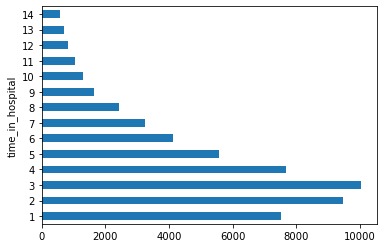

In [44]:
show_group_stats_viz(processed_df_tf, PREDICTOR_FIELD)

time_in_hospital
1     4519
2     5684
3     6017
4     4608
5     3340
6     2473
7     1939
8     1451
9      993
10     775
11     632
12     484
13     421
14     343
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


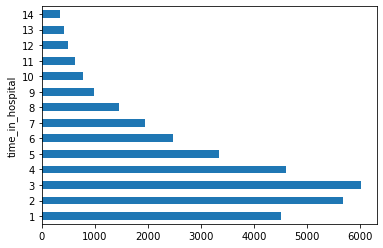

In [45]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1     1506
2     1894
3     2006
4     1537
5     1113
6      825
7      646
8      484
9      331
10     258
11     211
12     162
13     140
14     114
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


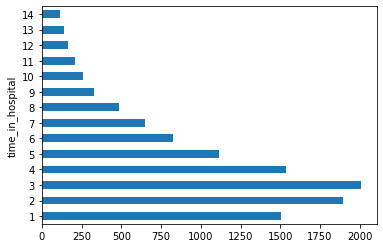

In [46]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             29583
Male               26548
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


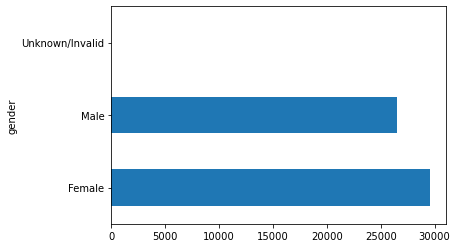

In [47]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df_tf[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    17720
Male      15959
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


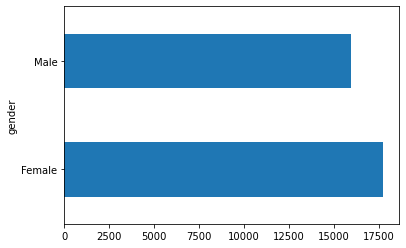

In [48]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             5943
Male               5283
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


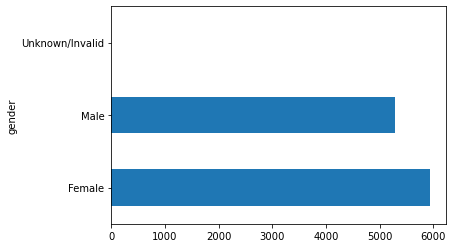

In [49]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [50]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [51]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [52]:
vocab_file_list = build_vocab_files(d_train, cat_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [53]:
tf_cat_col_list = create_tf_categorical_feature_cols(cat_col_list)

INFO:tensorflow:vocabulary_size = 469 in generic_drug_name is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/generic_drug_name_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 607 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elemen

In [54]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='generic_drug_name', vocabulary_file='./diabetes_vocab/generic_drug_name_vocab.txt', vocabulary_size=469, num_oov_buckets=1, dtype=tf.string, default_value=-1))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
t

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [55]:
def create_tf_numerical_feature_cols(numerical_col_list):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        tf_numeric_feature = tf.feature_column.numeric_column(key=c, default_value=0, dtype=tf.float64)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list
tf_cont_col_list = create_tf_numerical_feature_cols(num_col_list)

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [56]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='normalized_number_outpatient', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=None)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [ 0.631872  ]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [ 0.631872  ]
 [-0.27039126]
 [ 0.631872  ]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.27039126]
 [-0.

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [57]:
claim_feature_columns =tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [58]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [59]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=22)

Train for 264 steps, validate for 88 steps
Epoch 1/22
264/264 [==============================] - 6s 24ms/step - loss: 28.0408 - mse: 27.9476 - val_loss: 18.2173 - val_mse: 17.6268
Epoch 2/22
264/264 [==============================] - 4s 15ms/step - loss: 18.1578 - mse: 17.4950 - val_loss: 16.2844 - val_mse: 15.2449
Epoch 3/22
264/264 [==============================] - 4s 15ms/step - loss: 14.3092 - mse: 13.3951 - val_loss: 11.3206 - val_mse: 10.3189
Epoch 4/22
264/264 [==============================] - 4s 15ms/step - loss: 11.6972 - mse: 10.7248 - val_loss: 11.9598 - val_mse: 11.2790
Epoch 5/22
264/264 [==============================] - 4s 15ms/step - loss: 11.0752 - mse: 10.1295 - val_loss: 10.9752 - val_mse: 10.3270
Epoch 6/22
264/264 [==============================] - 4s 15ms/step - loss: 10.3991 - mse: 9.4483 - val_loss: 10.7004 - val_mse: 9.7564
Epoch 7/22
264/264 [==============================] - 4s 15ms/step - loss: 9.5727 - mse: 8.7318 - val_loss: 9.7961 - val_mse: 8.6889
Epoc

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [60]:
feature_list = cat_col_list + num_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [61]:
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [62]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [63]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,6.015933,3,5.288541,0.680455
1,2.854247,2,2.111270,0.686345
2,7.909099,1,3.922256,0.685158
3,10.371470,3,3.321572,0.683606
4,5.051183,9,8.891449,0.674878


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [64]:
binary_prediction = get_binary_prediction(prob_output_df, 'pred_mean', 'actual_value', 5)
binary_prediction.head()

,score,label_value
0,1,0
1,0,0
2,0,0
3,0,0
4,1,1


### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [65]:
def add_pred_to_test(test_df, binary_prediction, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df.reset_index(inplace=True)
    test_df = pd.concat([test_df, binary_prediction], axis=1)
    return test_df

pred_test_df = add_pred_to_test(d_test, binary_prediction, ['race', 'gender'])

In [66]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,40692663,Female,Caucasian,3,1,0
1,70111656,Male,Caucasian,2,0,0
2,24089553,Male,AfricanAmerican,1,0,0
3,14506839,Female,AfricanAmerican,3,0,0
4,964494,Female,Caucasian,9,1,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [67]:

y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values
print('accuracy_score:', accuracy_score(y_true, y_pred))
print()
print('f1_score:', f1_score(y_true, y_pred))
print()
print('classification_report:')
print(classification_report(y_true, y_pred))
print()
print('roc_auc_score:', roc_auc_score(y_true, y_pred))

accuracy_score: 0.7528280039191235

f1_score: 0.6964227108631442

classification_report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      6943
           1       0.66      0.74      0.70      4284

    accuracy                           0.75     11227
   macro avg       0.74      0.75      0.74     11227
weighted avg       0.76      0.75      0.76     11227


roc_auc_score: 0.7509455244001677


# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [68]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


model_id, score_thresholds 1 {'rank_abs': [4857]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)
/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


In [69]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,4857,race,AfricanAmerican,873,1192,282,210,982,591,801,1264,2065,11227
1,1,binary 0/1,4857,race,Asian,27,46,9,5,41,18,23,50,73,11227
2,1,binary 0/1,4857,race,Caucasian,3684,4709,1288,820,3889,2396,3216,5177,8393,11227
3,1,binary 0/1,4857,race,Hispanic,83,139,37,24,115,46,70,152,222,11227
4,1,binary 0/1,4857,race,Other,79,101,31,12,89,48,60,120,180,11227
5,1,binary 0/1,4857,race,nan,111,183,27,30,153,84,114,180,294,11227
6,1,binary 0/1,4857,gender,Female,2632,3311,892,582,2729,1740,2322,3621,5943,11227
7,1,binary 0/1,4857,gender,Male,2225,3058,782,519,2539,1443,1962,3321,5283,11227
8,1,binary 0/1,4857,gender,Unknown/Invalid,0,1,0,0,1,0,0,1,1,11227


In [70]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,AfricanAmerican,0.74,0.78,0.18,0.32,0.22,0.26,0.82,0.68,0.18,0.42,0.39
1,race,Asian,0.78,0.82,0.11,0.33,0.18,0.22,0.89,0.67,0.01,0.37,0.32
2,race,Caucasian,0.75,0.75,0.17,0.35,0.25,0.25,0.83,0.65,0.76,0.44,0.38
3,race,Hispanic,0.66,0.76,0.17,0.45,0.24,0.34,0.83,0.55,0.02,0.37,0.32
4,race,Other,0.80,0.74,0.12,0.39,0.26,0.20,0.88,0.61,0.02,0.44,0.33
5,race,nan,0.74,0.85,0.16,0.24,0.15,0.26,0.84,0.76,0.02,0.38,0.39
6,gender,Female,0.75,0.75,0.18,0.34,0.25,0.25,0.82,0.66,0.54,0.44,0.39
7,gender,Male,0.74,0.76,0.17,0.35,0.24,0.26,0.83,0.65,0.46,0.42,0.37
8,gender,Unknown/Invalid,NaN,1.00,0.00,NaN,0.00,NaN,1.00,NaN,0.00,0.00,0.00


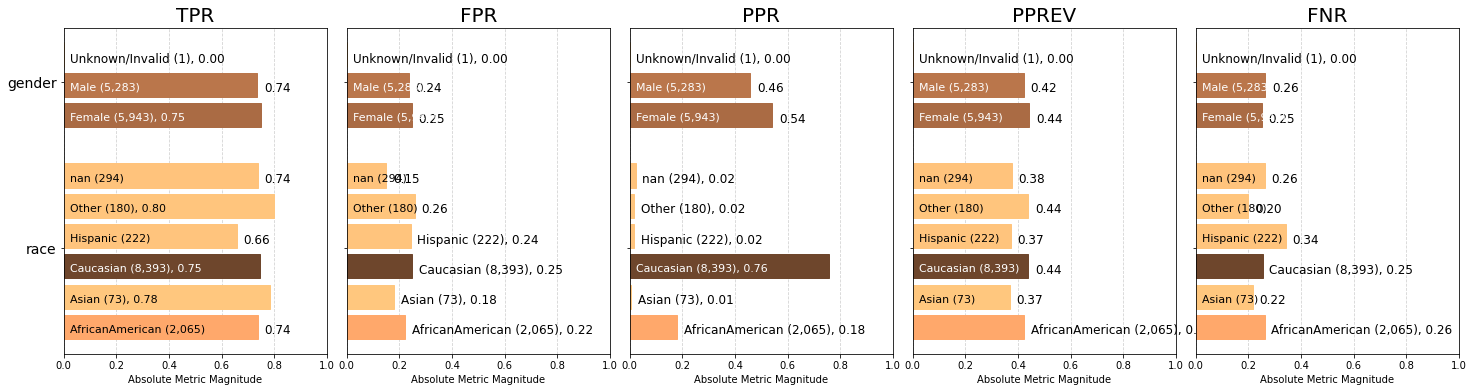

In [71]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [72]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

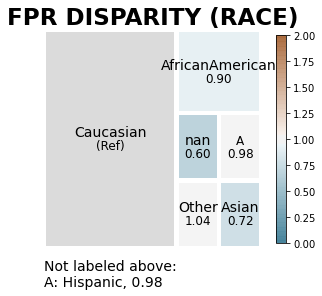

In [73]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

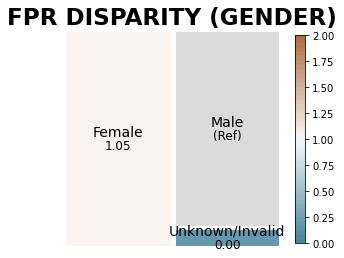

In [74]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

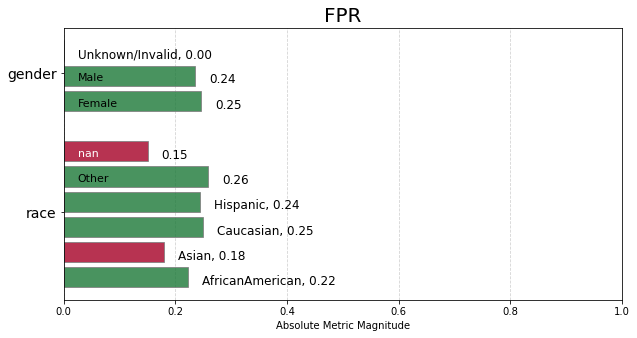

In [75]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)